In [1]:
import pandas as pd
import psycopg2 as pg2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as Pipeline_imb
import numpy as np




In [2]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [3]:
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='')
df = pd.read_sql ("""Select * from auction_full WHERE bid > 0""", conn)
df_backup = df.copy()

In [18]:
df = df_backup.copy()

In [19]:
df.columns

Index(['auctionid', 'is_winner', 'cardtype', 'cashvalue', 'cardvalue', 'fee',
       'bidvalue', 'limited_allowed', 'is_locked', 'auctiontime', 'bid',
       'is_bidomatic', 'bids_so_far', 'username', 'prevusers', 'username0',
       'distance0', 'is_bidomatic0', 'bids_so_far0', 'bom_bids_so_far0',
       'bom_streak0', 'perc_to_bin0', 'prev_win_bids0', 'username1',
       'distance1', 'is_bidomatic1', 'bids_so_far1', 'bom_bids_so_far1',
       'bom_streak1', 'perc_to_bin1', 'prev_win_bids1', 'username2',
       'distance2', 'is_bidomatic2', 'bids_so_far2', 'bom_bids_so_far2',
       'bom_streak2', 'perc_to_bin2', 'prev_win_bids2', 'username3',
       'distance3', 'is_bidomatic3', 'bids_so_far3', 'bom_bids_so_far3',
       'bom_streak3', 'perc_to_bin3', 'prev_win_bids3'],
      dtype='object')

In [20]:
df.is_bidomatic0 = df.is_bidomatic0.astype(str)
df.is_bidomatic1 = df.is_bidomatic1.astype(str)
df.is_bidomatic2 = df.is_bidomatic2.astype(str)
df.is_bidomatic3 = df.is_bidomatic3.astype(str)
#df["percent_near_bin0"] = df["bids_so_far0"]/(df["cashvalue"]*2.5)
#df["percent_near_bin1"] = df["bids_so_far1"]/(df["cashvalue"]*2.5)
#df["percent_near_bin2"] = df["bids_so_far2"]/(df["cashvalue"]*2.5)
#df["percent_near_bin3"] = df["bids_so_far3"]/(df["cashvalue"]*2.5)
#df[df["is_bidomatic0"]==False].streak0 = 0
#df[df["is_bidomatic1"]==False].streak1 = 0
#df[df["is_bidomatic2"]==False].streak2 = 0
#df[df["is_bidomatic3"]==False].streak3 = 0
df["fee"]=[0 if x == 0 else (1 if x < 50 else 1.99) for x in df["cardvalue"]]
df["time_of_day"]=[x.hour*60+x.minute for x in df["auctiontime"]]


In [21]:


y = df.pop('is_winner')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 


In [8]:
categorical_features = ['cardtype', 'limited_allowed', 'is_locked', 'is_bidomatic', 'is_bidomatic0', 'is_bidomatic1', 'is_bidomatic2', 'is_bidomatic3']
numeric_features = ['cashvalue','bidvalue', 'prevusers', 
                     'bids_so_far0', 'bom_streak0', 'perc_to_bin0',
                    'distance1', 'bids_so_far1', 'bom_streak1', 'perc_to_bin1',
                    'distance2', 'bids_so_far2', 'bom_streak2', 'perc_to_bin2',
                    'distance3', 'bids_so_far3', 'bom_streak3', 'perc_to_bin3', 'time_of_day']
numeric_transformer = Pipeline_imb(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
])
categorical_transformer = Pipeline_imb(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
model = Pipeline_imb(steps=[('preprocessor', preprocessor),
                        ('sampler', RandomUnderSampler()),
                      ('classifier', RandomForestClassifier())])


In [9]:
model.fit(X_train, y_train)

/home/pkgalea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=-1,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                             

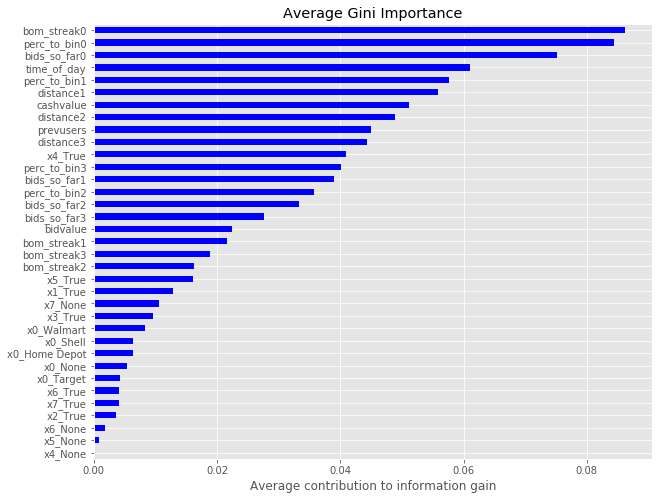

In [10]:
# Plot the feature importance
feat_scores = pd.Series(model.steps[2][1].feature_importances_,
                           index=get_column_names_from_ColumnTransformer(model.named_steps['preprocessor']))
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [11]:
probs = model.predict_proba(X_test)[:,1]
threshes = sorted(probs)

In [12]:
for thresh in np.arange(.5, 1,  .05):
    y_pred = probs > thresh
    cm = confusion_matrix(y_test, y_pred)
    print("*****************************")
    print("thresh:", thresh)
    print ("Accuracy {}: Precision: {}  Recall:{} ".format(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
    print(cm)
    true_positive_mask = (y_pred==True)&(y_test==True)
    profit = sum(X_test.cashvalue[true_positive_mask])-sum(y_pred)*.40 - sum(X_test.fee[true_positive_mask]) - sum(X_test.bid[true_positive_mask])/100
    profit_per_bid = profit/len(y_pred)
    print("profit:", profit)
    print("profit per bid:", profit_per_bid)
    print("*****************************")
    print("")

    


*****************************
thresh: 0.5
Accuracy 0.7550341660652258: Precision: 0.007576798845440176  Recall:0.6142061281337048 
[[178450  57763]
 [   277    441]]
profit: -4605.470000000003
profit per bid: -0.019438022040172045
*****************************

*****************************
thresh: 0.55
Accuracy 0.7550341660652258: Precision: 0.007576798845440176  Recall:0.6142061281337048 
[[178450  57763]
 [   277    441]]
profit: -4605.470000000003
profit per bid: -0.019438022040172045
*****************************

*****************************
thresh: 0.6000000000000001
Accuracy 0.837771334270315: Precision: 0.008649662611051767  Recall:0.4623955431754875 
[[198162  38051]
 [   386    332]]
profit: -2230.720000000001
profit per bid: -0.009415061769038249
*****************************

*****************************
thresh: 0.6500000000000001
Accuracy 0.837771334270315: Precision: 0.008649662611051767  Recall:0.4623955431754875 
[[198162  38051]
 [   386    332]]
profit: -2230.72000

In [13]:
plt.hist(X_test.bid[true_postive_mask], bins=max(X_test.bid[true_postive_mask]))

NameError: name 'true_postive_mask' is not defined

In [ ]:
probs

In [ ]:
df.groupby("cardvalue").mean()

In [ ]:
X_test[true_positive_mask]

In [ ]:
sum(y_test)

In [ ]:
sum(y_pred)

In [ ]:
len(np.unique(probs))

In [ ]:
df.auctiontime[0].minute

In [ ]:
y_pred = model.predict(X_test)
roc = roc_curve(y_test, y_pred)

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
y_test.shape

In [ ]:
y_pred.shape

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
model.predict_proba(X_test)


In [ ]:
true_positive_mask = (y_pred==True)&(y_test==True)
profit = sum(X_test.cashvalue[true_positive_mask])-sum(y_pred)*.40 - sum(X_test.fee[true_positive_mask]) - sum(X_test.bid[true_positive_mask])/100


In [ ]:
profit

In [14]:
conn.close()